In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

TO DO:

* ~~normalize the time series before taking the correlation~~
* ✓ use normalized correlation measure
* ✓ do a partitioning based on similarity
* ✓ sort adjacency matrix based on similarity
* ✓ visualize the partition
* ✓ stackplot of activity broken down by partitition
* use a better correlation metric--do the math correctly
  * ✓ take the log of activity before correlating
* move most of this to the libraries
* order groups reliably by time
  * in data
  * in plot
* summarize groups
* entity resolution on participants
* convolve the time series with a declining 'response time'

In [2]:
%matplotlib inline

Resources for this:

http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html  !!!

http://www.fil.ion.ucl.ac.uk/~wpenny/course/array.pdf

http://stats.stackexchange.com/questions/29096/correlation-between-two-time-series

http://perso.crans.org/aynaud/communities/api.html

In [3]:
from bigbang.archive import Archive

arx = Archive("scipy-user",archive_dir="../archives")

Get the activity of a list

In [4]:
act = arx.get_activity()

Since are going to be computing correlations between N different time series data sets and that's an $O(N^2)$ operation, let's limit N.

In [5]:
cutoff = 20

def filtered_participants(cutoff):
    xc = act.sum() > cutoff
    return act.columns[xc]

filtered_participants(cutoff)[:10]

Index([u'Chris.Barker@noaa.... (Christopher Barker)', u'Dharhas.Pothina@twdb.state.tx... (Dharhas Pothina)', u'Fernando.Perez at colorado.edu (Fernando Perez)', u'Giovanni.Samaey at cs.kuleuven.ac.be (Giovanni Samaey)', u'JRadinger@gmx... (Johannes Radinger)', u'Jerome.Kieffer@esrf... (Jerome Kieffer)', u'Karl.Young@ucsf.... (Karl Young)', u'L.Ulferts@hs-osnabrue... (L.Ulferts@hs-osnabrue...)', u'Pierre.RAYBAUT@C... (Pierre.RAYBAUT@C...)', u'R.Springuel@umit.maine.... (R. Padraic Springuel)'], dtype='object')

In [6]:
xc = act.sum() > cutoff
print act.shape
print 

(5003, 4111)



In [7]:
from scipy.stats.stats import pearsonr  

fc = filtered_participants(cutoff)

n = len(fc)

pc = np.zeros([n,n])

for i in range(0,n):
    for j in range(i,n):
        # since pearson correlation assumes normally distributed data
        # and we believe activity to be log-normally distributed (see Shalizi...)
        # we'll take the log of values here
        si = np.log1p(act[fc[i]])
        sj = np.log1p(act[fc[j]])

        c = pearsonr(si,sj)[0]
        pc[i,j] = c
        pc[j,i] = c
        
pc

array([[ 1.        ,  0.11676837, -0.01500432, ..., -0.00551488,
        -0.00552229, -0.00711201],
       [ 0.11676837,  1.        , -0.01628325, ..., -0.00598495,
        -0.005993  , -0.00771822],
       [-0.01500432, -0.01628325,  1.        , ..., -0.00697589,
        -0.00698527, -0.00899615],
       ..., 
       [-0.00551488, -0.00598495, -0.00697589, ...,  1.        ,
        -0.00256745, -0.00330656],
       [-0.00552229, -0.005993  , -0.00698527, ..., -0.00256745,
         1.        ,  0.02930758],
       [-0.00711201, -0.00771822, -0.00899615, ..., -0.00330656,
         0.02930758,  1.        ]])

In [8]:
G = nx.Graph(pc)
labels = dict(enumerate(fc))
G = nx.relabel_nodes(G,labels)

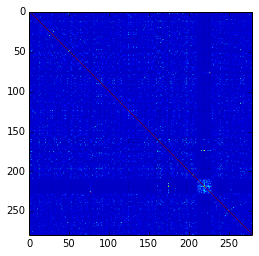

In [9]:
plt.imshow(pc)

In [10]:
# from http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html

import networkx as nx
from matplotlib import pyplot, patches

def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[],cmap="Greys"):
    """
    - G is a networkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = pyplot.figure(figsize=(5, 5)) # in inches
    pyplot.imshow(adjacency_matrix,
                  cmap=cmap,
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = pyplot.gca()
    current_idx = 0
    for partition, color in zip(partitions, colors):
        #for module in partition:
        ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                      len(partition), # Width
                                      len(partition), # Height
                                      facecolor="none",
                                      edgecolor=color,
                                      linewidth="1"))
        current_idx += len(partition)

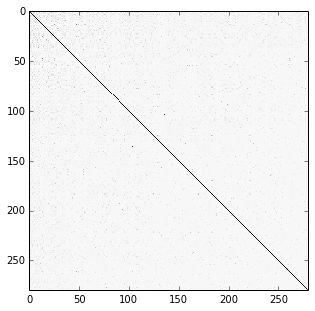

In [11]:
# order nodes by number of messages sent by each participant
o = list(act[fc].sum().order(ascending=False).keys())
draw_adjacency_matrix(G,node_order=o)

In [12]:
from sklearn import cluster

n_clusters = 5
sc = cluster.SpectralClustering(n_clusters=n_clusters)
partition = sc.fit_predict(pc)
partition_order = [fc[x] for x in np.argsort(partition)]

/home/sb/anaconda/envs/bigbang/lib/python2.7/site-packages/sklearn/cluster/spectral.py:421: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [13]:
np.sort(partition)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4], dtype=int32)

In [14]:
from collections import defaultdict

parts = defaultdict(list)
for i in range(len(partition)):
    parts[partition[i]].append(fc[i])
    
colors = [plt.cm.hsv(1. / (k + 1)) for k in parts.keys()]

In [15]:
colors

[(1.0, 0.0, 0.09375, 1.0),
 (0.0, 1.0, 0.96470316317617644, 1.0),
 (0.03124934374934376, 1.0, 1.3125013124790507e-06, 1.0),
 (0.51764557646910592, 1.0, 0.0, 1.0),
 (0.81874881874881877, 1.0, 0.0, 1.0)]

In [16]:
len(parts.values())

5

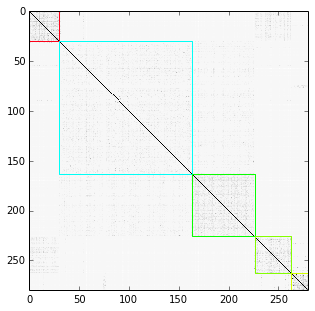

In [17]:
draw_adjacency_matrix(G,
                      node_order=partition_order,
                      partitions=parts.values(),
                      colors=colors)

In [18]:
for k,v in parts.items():
    print str(k) + ": " + str(len(v))

0: 30
1: 133
2: 63
3: 37
4: 17


In [ ]:
node_parts = {}

for k,v in parts.items():
    for n in v:
        node_parts[n] = int(k)

In [ ]:
import networkx as nx

#FG = nx.Graph(pc > .01)
FG = nx.from_numpy_matrix(pc * (pc > 0))

labels = dict(enumerate(fc))
FG = nx.relabel_nodes(FG,labels)
nx.set_node_attributes(FG,'corr-cluster',node_parts)


pos = nx.spring_layout(FG, k = 0.6, iterations = 1000)
nx.draw(FG,pos)
nx.write_gexf(FG,'corr.gexf')

In [ ]:
from bigbang import plot

plot.stack(act,partition=parts,smooth=7)

In [ ]:
parts.items()